In [1]:
%load_ext autoreload
%autoreload 1
import cbc_dp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pyqtgraph as pg
import skimage
from scipy.ndimage.filters import median_filter
from scipy import constants

In [2]:
rot_axis = [0, 1, 0]
pix_size = 75 * 1e-3
det_dist = 101.97604579545913
wavelength = constants.h * constants.c / 17000 / constants.e
exp_set = cbc_dp.ExperimentSettings(axis=rot_axis,
                                    pix_size=pix_size,
                                    det_dist=det_dist,
                                    wavelength=wavelength)

In [3]:
scan = cbc_dp.Scan1D(prefix='b12_2', scan_num=135)
data = scan.data
cor_data = scan.corrected_data()

In [6]:
idxs = np.where(bad_mask == 0)
proc_data = data[:, idxs[0], idxs[1]]
bgd_data = median_filter(proc_data, (10, 1))
background = np.copy(data)
background[:, idxs[0], idxs[1]] = bgd_data
sub_data = (data - background).astype(np.int64)

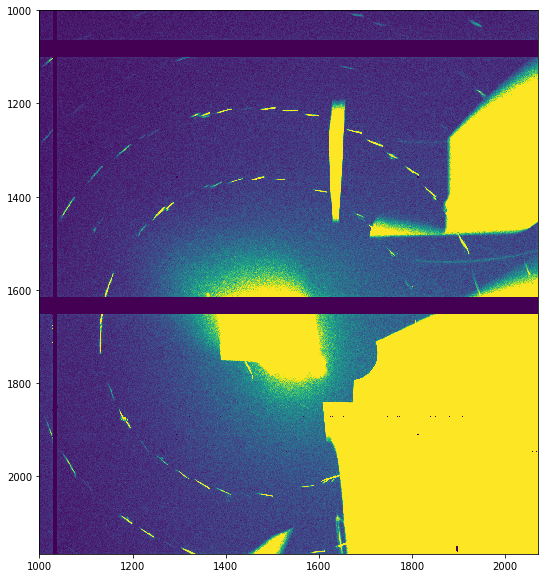

In [87]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.imshow(data[0], vmin=0, vmax=100)
plt.xlim(1000, 2070)
plt.ylim(2167, 1000)
plt.show()

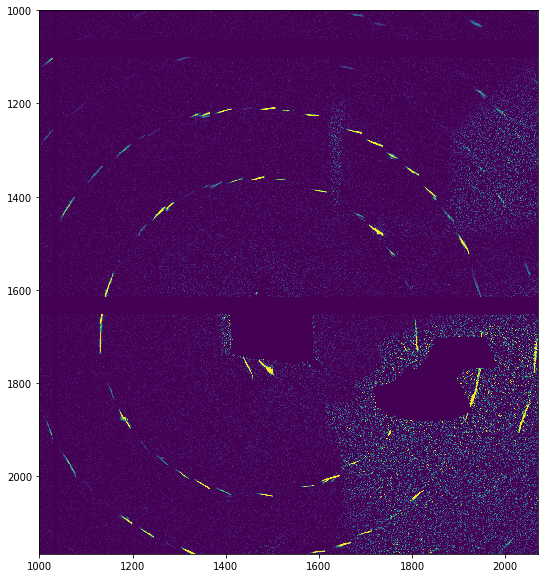

In [89]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.imshow(cor_data.cor_data[0], vmin=0, vmax=100)
plt.xlim(1000, 2070)
plt.ylim(2167, 1000)
plt.show()

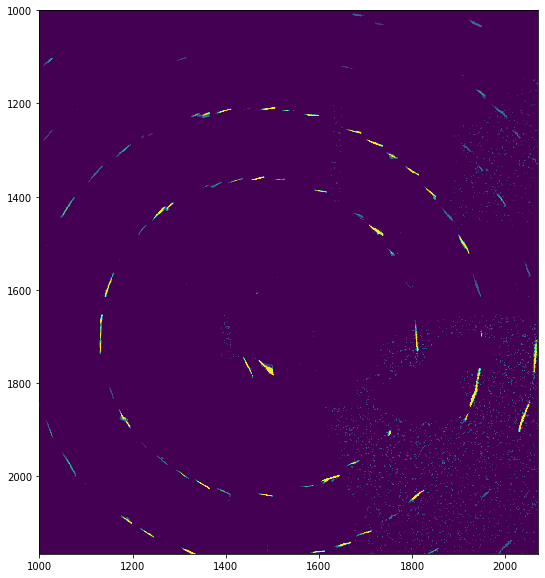

In [90]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.imshow(cor_data.strks_data[0], vmin=0, vmax=100)
plt.xlim(1000, 2070)
plt.ylim(2167, 1000)
plt.show()

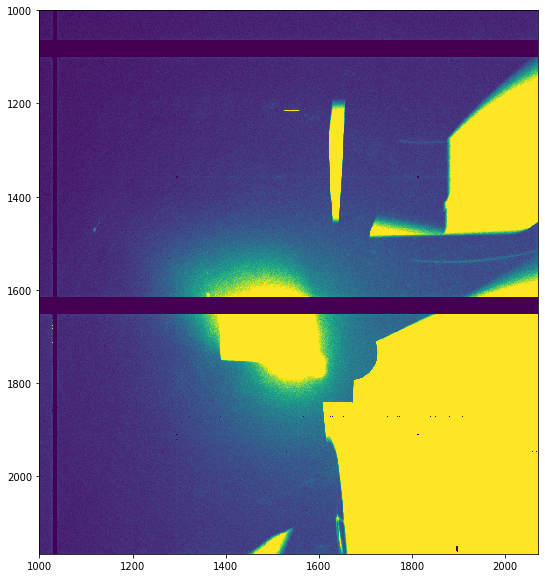

In [88]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.imshow(cor_data.background[0], vmin=0, vmax=100)
plt.xlim(1000, 2070)
plt.ylim(2167, 1000)
plt.show()

In [4]:
lsd = cbc_dp.LineSegmentDetector()
strks = lsd.det_scan(cor_data.strks_data,
                     zero=np.array([1470, 1710]),
                     drtau=20,
                     drn=10)
# qs = strks.rec_vectors(exp_set=exp_set,
#                        thetas=np.radians(np.arange(100)),
#                        pixels=15)

In [10]:
qs_list = []
for strk, theta in zip(strks, np.radians(np.arange(100))):
    rot_m = exp_set.rotation_matrix(theta)
    rec_vec = exp_set.rec_project(radii=strk.radii, angles=strk.angles)
    qs_list.append(rot_m.dot(rec_vec))
qs = np.concatenate(qs_list, axis=1)
qs.shape

(3, 9274)

In [7]:
cbc_dp.ReciprocalPeaks._refiner(strks.qs, counts=strks.shapes, dk=exp_set.pixtoq(15))

AttributeError: 'ScanStreaks' object has no attribute 'qs'

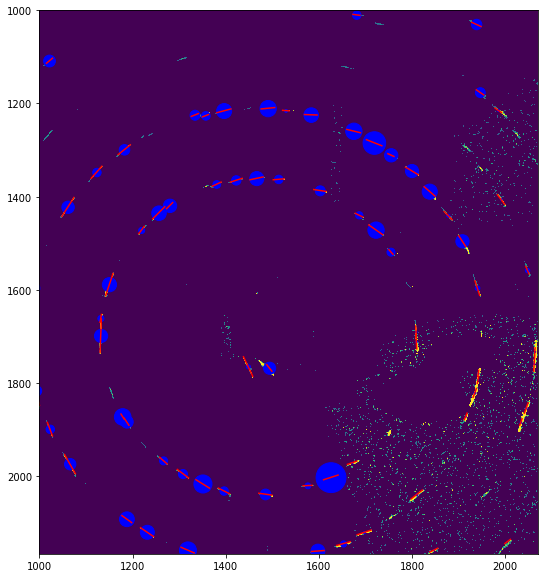

In [18]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.imshow(cor_data.strks_data[0], vmin=0, vmax=40)
for line in det_frame:
    plt.plot(line[:, 0], line[:, 1], 'r')
pts = det_frame.lines.mean(axis=1)
plt.scatter(pts[:, 0], pts[:, 1], snr * 30, 'b')
plt.xlim(1000, 2070)
plt.ylim(2167, 1000)
plt.show()

In [20]:
intensities = det_frame.intensities(cor_data.strks_data[0])
noises = []
for line in det_frame:
    rows, columns, val = skimage.draw.line_aa(line[0, 1], line[0, 0], line[1, 1], line[1, 0])
    noises.append(np.abs(cor_data.background[0][rows, columns] * val).sum())
snr = intensities / np.array(noises)

In [7]:
rot_m = cbc_dp.utils.rotation_matrix(rot_axis, np.pi / 2)
qs = np.concatenate((np.identity(3), np.identity(3)), axis=0)
print(qs, qs.shape)
print(qs.dot(rot_m.T), end='\n\n')
print(cbc_dp.utils.rotate(rot_m, qs[:, 0], qs[:, 1], qs[:, 2]), sep='\n')

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] (6, 3)
[[ 2.22044605e-16  0.00000000e+00 -1.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00  2.22044605e-16]
 [ 2.22044605e-16  0.00000000e+00 -1.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00  2.22044605e-16]]

(array([2.22044605e-16, 0.00000000e+00, 1.00000000e+00, 2.22044605e-16,
       0.00000000e+00, 1.00000000e+00]), array([0., 1., 0., 0., 1., 0.]), array([-1.00000000e+00,  0.00000000e+00,  2.22044605e-16, -1.00000000e+00,
        0.00000000e+00,  2.22044605e-16]))


In [12]:
qs.shape

(3, 6)